# **XGBoost** #



## **Step 1 – Load the Data** ## 

In this step,the preprocessed CSV dataset is loaded into a pandas DataFrame. We also perform a basic inspection to ensure the structure is correct and there are no missing values. This ensures the dataset is ready for splitting and modeling in the next steps.

Next, we check the dataset for structural consistency and completeness. We use .info() to verify data types and non-null entries, and .isnull().sum() to confirm that there are no missing values. To understand the class distribution for the binary target variable fraud, we print the value counts. Lastly, we review the dataset shape and basic statistics using .shape and .describe() to get a first sense of the feature distributions.

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../Data/Fraud_Cleaned.csv")

# Display first few rows
df.head()


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModification,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429,0
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259,0
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000,0
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857,0
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526,0


In [2]:
# Check for basic structure and null values
df.info()

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Preview the distribution of the target variable
print("\nTarget variable distribution:")
print(df['fraud'].value_counts())
print()

print(f"Dataset shape: {df.shape}")
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498050 entries, 0 to 498049
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   trustLevel                 498050 non-null  int64  
 1   totalScanTimeInSeconds     498050 non-null  int64  
 2   grandTotal                 498050 non-null  float64
 3   lineItemVoids              498050 non-null  int64  
 4   scansWithoutRegistration   498050 non-null  int64  
 5   quantityModification       498050 non-null  int64  
 6   scannedLineItemsPerSecond  498050 non-null  float64
 7   valuePerSecond             498050 non-null  float64
 8   lineItemVoidsPerPosition   498050 non-null  float64
 9   fraud                      498050 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 38.0 MB
Missing values per column:
trustLevel                   0
totalScanTimeInSeconds       0
grandTotal                   0
lineItemVoids                0
sca

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModification,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
count,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000
mean,3.503243,915.605811,49.996116,5.495896,5.001377,2.499034,0.068059,0.222214,0.735200,0.047634
std,1.707661,528.773256,28.869314,3.447630,3.163808,1.708176,0.521129,1.717987,1.320275,0.212990
min,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000546,0.000005,0.000000,0.000000
25%,2.000000,458.000000,24.940000,3.000000,2.000000,1.000000,0.008682,0.027360,0.161667,0.000000
50%,4.000000,916.000000,50.040000,5.000000,5.000000,2.000000,0.016940,0.054557,0.352941,0.000000
75%,5.000000,1374.000000,75.020000,8.000000,8.000000,4.000000,0.033929,0.109102,0.692308,0.000000
max,6.000000,1831.000000,99.990000,11.000000,10.000000,5.000000,30.000000,99.710000,11.000000,1.000000


## **Step 2 – Feature and Target Separation** ##

In this step, the dataset is split into:

- Features (X): all input variables used for prediction.

- Target (y): the label we want to predict — in this case, whether a transaction is fraudulent (fraud = 1) or not (fraud = 0).

In [3]:
# Define target variable
y = df['fraud']

# Define features (all columns except 'fraud')
X = df.drop(columns=['fraud'])

# Check the shape of feature and target sets
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)


Feature matrix shape: (498050, 9)
Target vector shape: (498050,)


## **Step 3 – Stratified Train-Test Split** ##

The dataset is split into training, validation, and test sets using stratified sampling. We first split the data into 70% training data and 30% temporary data. Then, the remaining 30% is evenly split into 15% validation and 15% test sets.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")



Train: (348635, 9), Val: (74707, 9), Test: (74708, 9)


## **Step 4 – Initialize and Train the XGBoost Model (Baseline)** ##

In this step, we initialize the XGBClassifier with basic settings (default hyperparameters). This baseline model helps to understand how well XGBoost performs without tuning. Later, we will improve it using cross-validation and hyperparameter optimization.

In [5]:
from xgboost import XGBClassifier

# Calculate the imbalance ratio
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize model with imbalance handling
xgb_model = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=ratio,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

#------------------------------------------
# Train the model
# xgb_model.fit(X_train, y_train)

# Predict probabilities (for threshold tuning)
# y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Optional: Predict class with default threshold 0.5
# y_pred = xgb_model.predict(X_test)
#-------------------------------------------


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## **Step 5 – Cross-Validation and Evaluation (Baseline Metrics)** ##

Before tuning the model, we want to evaluate how well it performs using cross-validation. Cross-validation gives us a more reliable estimate of model performance than a single train/test split. We’ll use Stratified K-Fold to maintain class balance in each fold.

We also evaluate multiple classification metrics:

- Accuracy
- Precision
- Recall
- F1 Score
- ROC-AUC
- Matthews Correlation Coefficient (MCC)





In [6]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'mcc': make_scorer(matthews_corrcoef)
}

# Create stratified K-fold object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation
cv_results = cross_validate(
    estimator=xgb_model,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
)


# Display average scores
print("Average cross-validation results (5-fold):")
for metric in scoring.keys():
    print(f"{metric}: {np.mean(cv_results[f'test_{metric}']):.4f}")

Average cross-validation results (5-fold):
accuracy: 0.9927
precision: 0.8691
recall: 0.9982
f1: 0.9292
roc_auc: 0.9999
mcc: 0.9278


## **Step 6 – Feature Importance Analysis** ##

In this step, we examine which features the XGBoost model considers most important when making predictions. This helps us:

- Understand which variables drive the model
- Justify our model decisions in the documentation
- Potentially simplify the model by removing low-impact features

XGBoost provides built-in feature importance scores, which can be visualized to make interpretation easier.

<Figure size 1000x600 with 0 Axes>

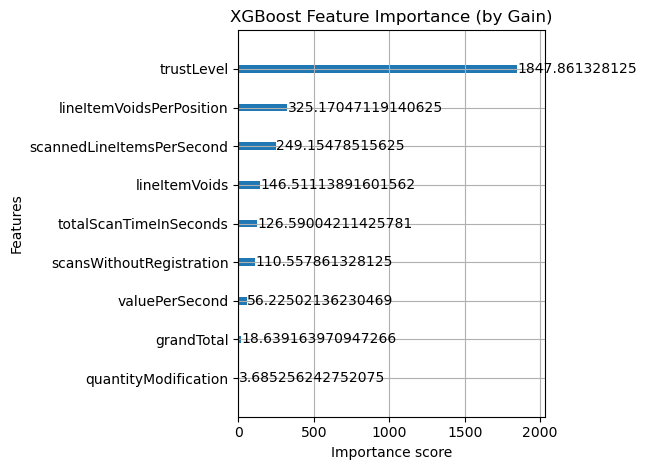

In [7]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Re-train the model only on the training set
xgb_model.fit(X_train, y_train)

# Plot feature importance using 'gain'
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='gain', max_num_features=9)
plt.title("XGBoost Feature Importance (by Gain)")
plt.tight_layout()
plt.show()


## **Step 7 – Hyperparameter Tuning with RandomizedSearchCV** ##

In this step, we optimize the most important hyperparameters of the XGBoost model using RandomizedSearchCV. Compared to GridSearchCV, this approach is more efficient because it samples combinations randomly rather than testing all possible ones.

We’ll focus on the most impactful parameters for model performance and overfitting control.

In [8]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_lambda': [1, 5, 10]  # L2 regularization
}

# Calculate imbalance ratio again
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize classifier with imbalance handling
xgb_clf = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=ratio,
    random_state=42
)

# Set up randomized search with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    scoring='f1',
    n_iter=30,  # Number of combinations to try
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run hyperparameter tuning
random_search.fit(X_train, y_train)

# Show best parameters
print("Best parameters found:")
print(random_search.best_params_)

# Best estimator
best_model = random_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found:
{'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 1.0}


After running a randomized hyperparameter search with 30 different parameter combinations using 5-fold cross-validation, the best-performing configuration, measured by the F1 score, are seen above.

This result suggests that the most effective model setup builds 400 shallow trees (maximum depth of 3), using 80% of the training data per tree (subsample=0.8) and all features (colsample_bytree=1.0). It uses moderate regularization (reg_lambda=5, gamma=1) to reduce overfitting, and a learning rate of 0.2 to balance training speed and stability. Overall, this configuration strikes a good balance between model complexity and generalization, making it well-suited for the fraud detection task.

## **Step 8 – Threshold Tuning on the Validation Set** ##

In this step, we use the best-performing model identified during hyperparameter tuning (Step 7) to predict fraud probabilities on the validation set. Instead of relying on a default threshold of 0.5, we systematically evaluate multiple threshold values to find the one that minimizes the total cost of misclassification.

To reflect the real-world business impact, we define a cost function where false positives (i.e., predicting fraud when there is none) are five times more expensive than false negatives. For each threshold value, we compute classification metrics such as accuracy, precision, recall, F1 score, ROC-AUC, and Matthews Correlation Coefficient, as well as the total cost using the defined cost function.

We then select the threshold that results in the lowest total cost. The confusion matrix for this optimal threshold is visualized to better understand the distribution of prediction outcomes. Additionally, we plot the relationship between threshold values and total cost to support our threshold selection.

Importantly, the test set remains untouched at this stage to ensure an unbiased final evaluation, which will be conducted in the next step.



Best threshold (validation set): 0.9000000000000002
Lowest total cost (validation set): 263.0
Threshold         0.900000
TP             3460.000000
FP               33.000000
FN               98.000000
TN            71116.000000
Total Cost      263.000000
Accuracy          0.998246
Precision         0.990553
Recall            0.972456
F1                0.981421
ROC AUC           0.985996
MCC               0.980547
Name: 16, dtype: float64


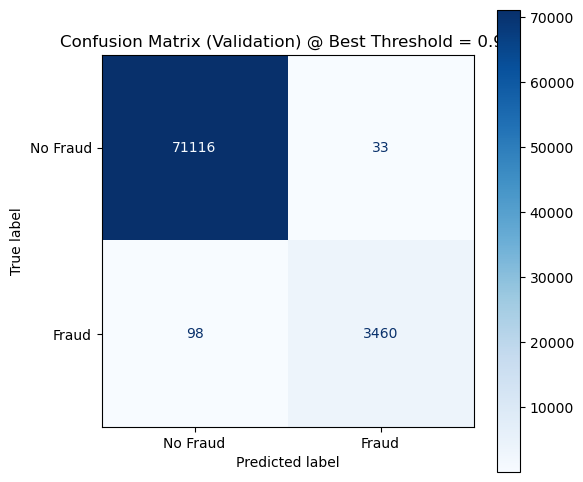

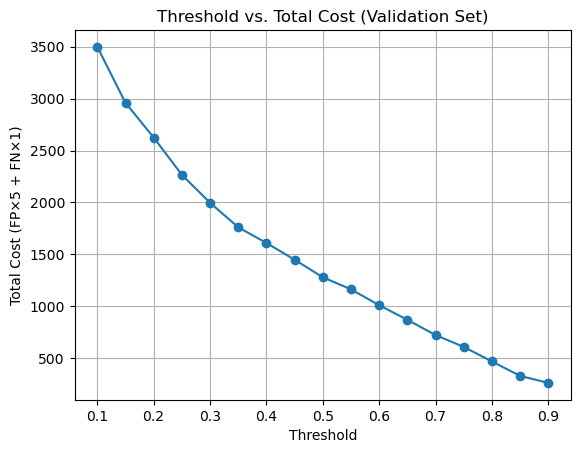

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef, ConfusionMatrixDisplay
)

# Step 1: Define evaluation function
def evaluate_threshold(y_true, y_proba, threshold, fp_cost=5, fn_cost=1):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = fp * fp_cost + fn * fn_cost
    return {
        "Threshold": threshold,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn,
        "Total Cost": total_cost,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_true, y_pred),
        "MCC": matthews_corrcoef(y_true, y_pred)
    }

# Step 2: Evaluate multiple thresholds on validation set
thresholds = np.arange(0.1, 0.91, 0.05)
y_val_proba = best_model.predict_proba(X_val)[:, 1]
results = [evaluate_threshold(y_val, y_val_proba, t) for t in thresholds]
results_df = pd.DataFrame(results)

# Step 3: Print and plot best result
best_result = results_df.loc[results_df['Total Cost'].idxmin()]
best_threshold = best_result['Threshold']
print("Best threshold (validation set):", best_threshold)
print("Lowest total cost (validation set):", best_result['Total Cost'])
print(best_result)

# Step 4: Show confusion matrix for best threshold (validation set)
y_val_pred_best = (y_val_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_val, y_val_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraud", "Fraud"])
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
plt.title(f"Confusion Matrix (Validation) @ Best Threshold = {best_threshold:.2f}")
plt.grid(False)
plt.show()

# Step 5: Plot cost vs threshold
plt.plot(results_df['Threshold'], results_df['Total Cost'], marker='o')
plt.xlabel("Threshold")
plt.ylabel("Total Cost (FP×5 + FN×1)")
plt.title("Threshold vs. Total Cost (Validation Set)")
plt.grid(True)
plt.show()


## **Step 9 – Saving the Final Model and Optimal Threshold** ##

After identifying the best-performing model through hyperparameter tuning and determining the cost-optimal classification threshold on the validation set, we now save both components for future use. The trained XGBoost model is serialized and saved using joblib, which preserves the model’s structure and learned parameters. Additionally, we save the selected threshold value in a separate text file. This threshold will later be used to make consistent and cost-sensitive predictions during the final evaluation on the test set and in any deployment scenario. Storing both the model and threshold ensures reproducibility and allows us to apply the exact decision rule in future predictions.

In [12]:
import joblib

# Save the model
joblib.dump(best_model, "final_xgboost_model.pkl")

# Save threshold (you can also put this in a config file or database)
with open("xgboost_final_threshold.txt", "w") as f:
    f.write(str(best_threshold))

## **Step 10a – Final Evaluation on the Test Set** ##
In this final step, we evaluate the performance of the tuned XGBoost model using the previously selected optimal threshold. The model is applied to the unseen test set to generate fraud predictions. We then assess the model using all key classification metrics, including accuracy, precision, recall, F1 score, ROC-AUC, and MCC. Additionally, we calculate the total cost of misclassification, considering that false positives are five times more expensive than false negatives. A confusion matrix is also displayed to visualize the prediction results.



=== Final Evaluation on Test Set ===
Threshold used: 0.90
Total cost: 291
Confusion Matrix: TP=3453, FP=37, FN=106, TN=71112
Accuracy: 0.9981
Precision: 0.9894
Recall: 0.9702
F1 Score: 0.9797
ROC-AUC: 0.9848
MCC: 0.9788


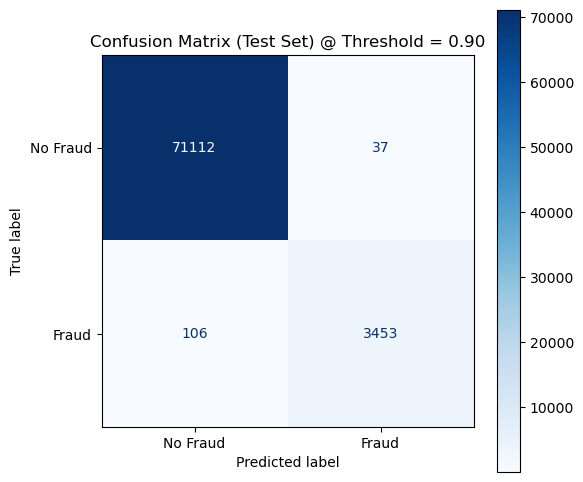

In [13]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Step 1: Predict probabilities on the test set
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Step 2: Apply the optimal threshold from validation
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Step 3: Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

# Step 4: Calculate cost (FP = 5×, FN = 1×)
total_cost = fp * 5 + fn * 1

# Step 5: Compute all metrics
print("=== Final Evaluation on Test Set ===")
print(f"Threshold used: {best_threshold:.2f}")
print(f"Total cost: {total_cost}")
print(f"Confusion Matrix: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_test_pred):.4f}")

# Step 6: Visualize confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraud", "Fraud"])
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
plt.title(f"Confusion Matrix (Test Set) @ Threshold = {best_threshold:.2f}")
plt.grid(False)
plt.show()


## **Step 10b – ROC Curve and AUC on the Test Set** ##

In this complementary step, we evaluate the overall discrimination ability of the final model by computing and plotting the Receiver Operating Characteristic (ROC) curve on the test set. The ROC curve illustrates how the model’s true positive rate and false positive rate vary across all possible classification thresholds. The Area Under the Curve (AUC) summarizes this performance into a single value, providing a threshold-independent measure of how well the model distinguishes between fraudulent and non-fraudulent cases. This analysis helps validate the model’s generalization ability and complements the cost-sensitive evaluation from Step 10a.



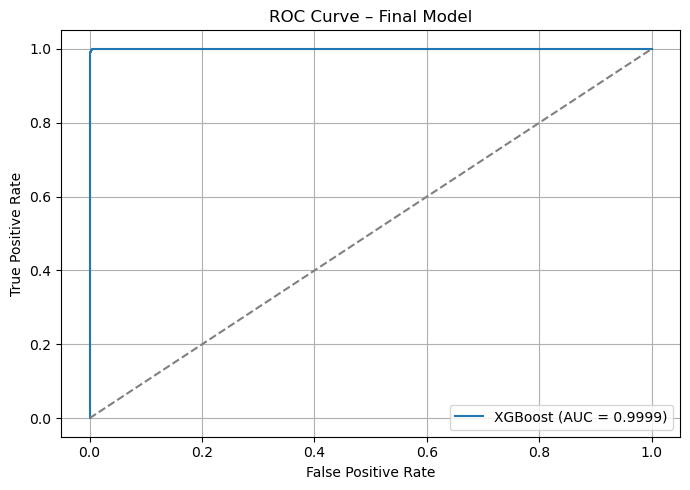

In [14]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (fraud = 1)
y_probs = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal = random model
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Final Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC Curve shows the model's ability to distinguish between fraud and non-fraud cases across all classification thresholds. An AUC value close to 1.0 indicates strong performance.